
# Transfer Learning & Fine Tuning

- 이론


- Transfer Learning
  - 이
- Convolutional Neural Network For Image Classification
  - Approach 1 :
  - Approach 2 :

## 이론
### Transfer Learning
- Transfer Learning은 이미 좋은 성능을 내는 신경망 모델의 conv 층과 pool 층의 가중치를 복사하여 새로 생성할 CNN모델에 적용한다. 그리고 적용된 파라미터는 학습하지말고 밀집신경망만 학습하여 새로운 모델을 생성한다

 \- 이것이 가능한 이유는 conv층은 이미지의 기본적인 특징을 가져오기 때문에 다른 분류기에 적용해도 좋은 성능을 낸다. 결국 분류를 하는것은 밀집신경망 층이기때문에 부분적 학습을 해도된다.

- conv층을 학습하지 않기때문에 비슷한 이미지 데이터를 활용하여 예측할때 효과가 좋다.

### Fine Tuning
- ㅇㅇ

### Importing the Libraries

In [31]:
import cv2
import numpy as np
import zipfile
from google.colab.patches import cv2_imshow
import tensorflow as tf
import seaborn as sns # 데이터 시각화
# 서로 다른 2개의 모델을 합치기 때문에 순차적은 아니다.
from tensorflow .keras.models import Model
# 전이 학습을 위해 모델 합치기위한 객체
from tensorflow.keras.layers import Dense, Input,GlobalAveragePooling2D, Dropout
# 이미지 전처리를 도와주는 객체( 테스트 데이터, 검증 데이터 분할, 이미지 늘리기 등 )
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.__version__

'2.15.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Datasets/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file= path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

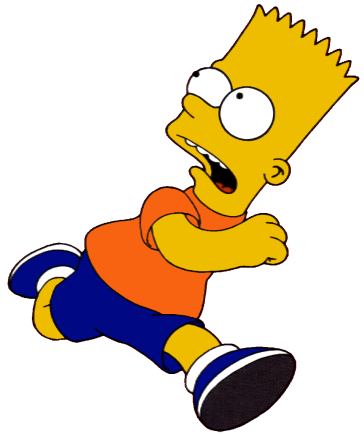

In [4]:
# tk 라이브러리를 활용한 이미지 불러오기
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')

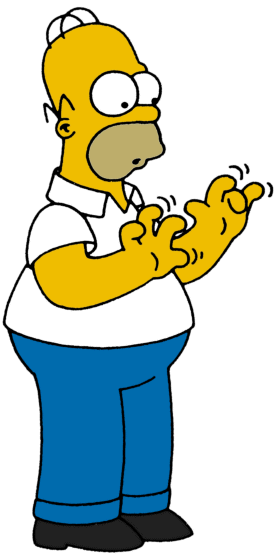

In [5]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer100.bmp')

### Train and Test set

In [6]:
training_generator = ImageDataGenerator(rescale= 1./255, rotation_range=7, horizontal_flip =True, zoom_range=0.2)

In [7]:
# flow_from_directory : 실제 데이터 로드, shuffle = true 한 이유는 순서가 일정하면 특징이 아닌 순서를 통한 학습을 하기때문
# batch_size : 학습시 한번에 모델이 처리하는 데이터의 개
train_dataset = training_generator.flow_from_directory('/content/homer_bart_2/training_set', target_size = (256, 256), batch_size =8, class_mode ='categorical', shuffle = True)

Found 215 images belonging to 2 classes.


In [8]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [9]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [10]:
test_generator = ImageDataGenerator(1./255)
# test dataset에선 batch_size가 1인데 각각의 이미지들이 혼자 들어가서 자기만의 특징을 추출해야하기 때문이다.
test_dataset = test_generator.flow_from_directory('/content/homer_bart_2/test_set', target_size = (256, 256), batch_size =1, class_mode = 'categorical', shuffle = False)

Found 54 images belonging to 2 classes.


### Pre-trained Network(사전 학습 모델) Loading
- ResNet : https://arxiv.org/pdf/1512.03385.pdf

- keras에서 제공하는 사전학습 가능한 모델들
  - documentation : https://keras.io/api/applications/

In [11]:
# 이미 구현된 ResNet구조를 가져올수있다. (문서를 보면 구조도 알려준다)
# tensorflow에서 제공하는 사전학습 모델들은 imagenet의 이미지들로 학습을 했기때문에 weights는 imagenet으로한다.
# include_top = True는 사전학습 모델의 밀집신경망까지 가져온다는 뜻이다. 이미 학습된 1000개의 이미지 분류기능을 사용할 수 있겠지만
# 사용자 정의 신경망을 만들기엔 필요없는 기능이다.
# input_tensor은 입력층을 설정하는것이다.
# 각 사전 학습 모델별로 가능한 shape이 다 다르다. 확인후에 개발자가 사용할 데이터의 크기를 지원하는 사전학습 모델을 선택하여야한다.
# 구조만 가져온다
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top=False,
                                            input_tensor = Input(shape = (256,256,3)))

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [15]:
# layer.trainable이 true면 가중치 학습때 파라미터가 변경된다. 따라서 전이학습시 False로 해야한다.
for layer in base_model.layers:
  print(layer, layer.trainable)
  layer.trainable=False

<keras.src.engine.input_layer.InputLayer object at 0x7ca89b2d47f0> True
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ca89b2d7eb0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ca8999bc1f0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ca8999bc670> True
<keras.src.layers.core.activation.Activation object at 0x7ca8999bd8d0> True
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ca8999bdea0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ca8999bee30> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ca8999bf5b0> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7ca899874ca0> True
<keras.src.layers.core.activation.Activation object at 0x7ca899876c80> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7ca899876560> True
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 

In [13]:
len(base_model.layers)

175

### 밀집 신경망 정의하고 연결하기
- conv층은 이미지에서 일반적인 특징을 찾는데 관련이 있고 밀집 신경망은 그러한 특징을 가지고 이 특징이 우리가 분류하고 싶은 클래스에 얼마나 갖고있는 가중치인지 분류하는 것이다.

In [18]:
# output은 모델의 마지막 출력 정보를 가지고있다.(conv층에 의해 생성, 8,8,2048형태로 데이터 출)
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [17]:
# 평탄화 함수를 사용할 수 있지만 GlobalAveragePooling2D()함수를 통해 평탄화 할수도 있다
# 출력된 행렬을 평균값을 이용하여 벡터로 변환해준다.
head_model = base_model.output
# 이전과 다르게 층을 연결하는것은 우리가 Sequential()을 임포트 아니라 model을 임포트하였기때문이다.
head_model = GlobalAveragePooling2D()(head_model)
# 은닉층1 (은닉층이 1025인 이유는 입력층(2048)+출력층(2)/2 = 1025이기때문이다.)
head_model = Dense(units = 1025, activation = 'relu')(head_model)
# Dropout을 통해 20% 뉴런들을 비활성화하여 과적합 방지
head_model = Dropout(rate = 0.2)(head_model)
# 은닉층2
head_model = Dense(units = 1025, activation = 'relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation ='softmax')(head_model)

In [19]:
# 인풋 shape 확인(이미지 크기)
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [20]:
# 두 신경망 연결하기 (Model (inputs = 입력에 사용될 신경망, outputs = 출력할 신경망))
network = Model(inputs = base_model.input, outputs= head_model)

In [21]:
# 주의점 : 요약의 평탄화의 입력shape을 보면 2048이다. 그냥 평탄화 함수를 썼으면 8*8*2048의 입력층이 나올것이다.
# 하지만 global_average_pooling2d를 사용함으로 입력층에 들어갈 데이터크기를 대폭 감소시킬수 있다.
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [23]:
network.compile(optimizer='Adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 [==============================] - 63s 2s/step - loss: 1.0019 - accuracy: 0.5953
Epoch 2/50
27/27 [==============================] - 56s 2s/step - loss: 0.6688 - accuracy: 0.6279
Epoch 3/50
27/27 [==============================] - 56s 2s/step - loss: 0.7769 - accuracy: 0.5581
Epoch 4/50
27/27 [==============================] - 55s 2s/step - loss: 0.6779 - accuracy: 0.5814
Epoch 5/50
20/27 [=====================>........] - ETA: 17s - loss: 0.6678 - accuracy: 0.6038

KeyboardInterrupt: 

### 모델 평가하기

In [25]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [26]:
predictions = network.predict(test_dataset)
predictions

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


54/54 [==============================] - 15s 247ms/step


array([[0.13451529, 0.86548465],
       [0.12772681, 0.8722732 ],
       [0.21741207, 0.7825879 ],
       [0.2120756 , 0.7879244 ],
       [0.28616387, 0.71383613],
       [0.16356674, 0.83643323],
       [0.25227028, 0.7477297 ],
       [0.39594644, 0.60405356],
       [0.14675833, 0.8532417 ],
       [0.29029903, 0.70970094],
       [0.26595306, 0.7340469 ],
       [0.2055974 , 0.7944026 ],
       [0.246552  , 0.75344795],
       [0.28605688, 0.7139431 ],
       [0.2613788 , 0.7386212 ],
       [0.3008476 , 0.69915247],
       [0.29036832, 0.7096316 ],
       [0.12819216, 0.8718078 ],
       [0.42351806, 0.57648194],
       [0.21926816, 0.78073186],
       [0.255215  , 0.7447851 ],
       [0.17437424, 0.8256258 ],
       [0.32136053, 0.6786395 ],
       [0.35046294, 0.649537  ],
       [0.30134535, 0.69865465],
       [0.23979354, 0.7602065 ],
       [0.33107156, 0.6689285 ],
       [0.30990884, 0.69009113],
       [0.30758592, 0.69241405],
       [0.21222152, 0.7877785 ],
       [0.

In [27]:
predictions = np.argmax(predictions, axis =1)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [28]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [29]:
# Approach 1(all pixels):0.68
# Approach 2(features):0.88
# Approach 3(CNN):0.92
# Approach 4(Transfer learning):0.81
# 위 결과를 보면 CNN보다 전이학습의 정확도가 낮다. 그 이유는 이미지넷 데이터와 우리가 사용한 데이터셋의 구성이 너무 다르기때문이다.
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.48148148148148145

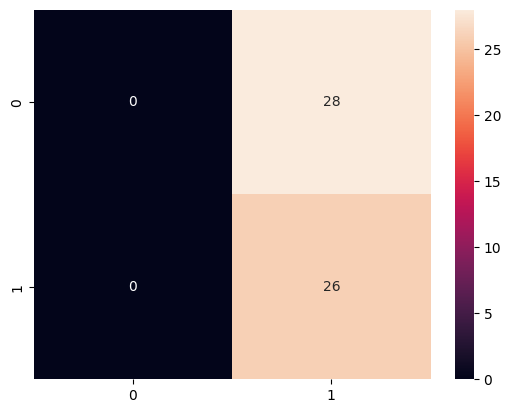

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True);

In [34]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.48      1.00      0.65        26

    accuracy                           0.48        54
   macro avg       0.24      0.50      0.33        54
weighted avg       0.23      0.48      0.31        54



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
